In [36]:
# import stuff
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

from random import randint
import numpy as np
import torch
import pandas as pd
import json
import scipy
import scipy.spatial

In [37]:
# Parameters
# separate_index = 50000
use_cuda = True
test_set_size = 200

## Load model

In [38]:
# Load model
from models import InferSent
model_version = 2
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

# Keep it on CPU or put it on GPU
model = model.cuda() if use_cuda else model

# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

Vocab size : 100000


## Read Dictionary

In [39]:
# read from csv
description_csv_file_name = "../results/description.csv"
df_description = pd.read_csv(description_csv_file_name)
df_description = df_description.replace(np.nan, "", regex=True)
print('length of df_description: ', len(df_description))
df_description.head()


length of df_description:  2360655


,book_id,description
0,5333265,
1,1333909,"Anita Diamant's international bestseller ""The ..."
2,7327624,Omnibus book club edition containing the Ladie...
3,6066819,Addie Downs and Valerie Adler were eight when ...
4,287140,


## Get similarity score

In [133]:
def generate_embeddings_and_compute_ranked_distance(book_text, similar_book_texts, print_mode=True, closest_n=20):
    if book_text == "":
        print("The input book description cannot be NULL")
        return -1
    temp_book_text = [book_text, "Meaningless"]
    book_embedding = model.encode(temp_book_text, bsize=128, tokenize=False)[0]
    similar_books_embeddings = model.encode(similar_book_texts, tokenize=True, verbose=True)
    distances = scipy.spatial.distance.cdist([book_embedding], similar_books_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    
    if print_mode == True:
        print("======================\n\n")
        print("Original book:", book_text[0:50], "...")
#     print("\nTop " + str(closest_n) + " most similar books:")
    
    accuracy = 0
    accuracy_closest_5 = 0
    count_iteration = 0
    for idx, distance in results:
        if count_iteration > closest_n: # we only consider clesest N results.
            break
        if similar_book_texts[idx] == "":
            continue # we don't take into account those books without any description
        similarity_score = 1 - distance
        accuracy += similarity_score
        count_iteration += 1
        if count_iteration <=5:
            accuracy_closest_5 = accuracy
        if print_mode == True:
            try:
                print(similar_book_texts.iloc[idx].strip()[0:50], "... ",  "(Score: %.4f)" % (similarity_score))
            except:
                print(similar_book_texts[idx].strip()[0:50], "... ",  "(Score: %.4f)" % (similarity_score))
    accuracy /= count_iteration
    accuracy_closest_5 /= count_iteration if count_iteration<5 else 5
    
    return accuracy, accuracy_closest_5

In [136]:
# need to modify the function above to make the accuracy part supports iloc
# generate_embeddings_and_compute_ranked_distance(df_description.description[1], df_description.description[1:20])

## Get accuracy

In [14]:
# Read the csv file first.
ground_truth_similar_books_csv = "../results/similar_books.csv"
df_similar_books_GT = pd.read_csv(ground_truth_similar_books_csv)
print('length of df_similar_books_GT: ', len(df_similar_books_GT))
df_similar_books_GT.head()

length of df_similar_books_GT:  2360655


,book_id,similar_books
0,5333265,[]
1,1333909,"['8709549', '17074050', '28937', '158816', '22..."
2,7327624,"['19997', '828466', '1569323', '425389', '1176..."
3,6066819,"['6604176', '6054190', '2285777', '82641', '75..."
4,287140,[]


In [76]:
# build a test set from df_similar_books_GT.
def get_test_set_similar_books_GT():
    similar_books_GT_test_dict = {}
    for i in range(test_set_size):
        temp_similar_books = df_similar_books_GT.iloc[i]['similar_books']
        if temp_similar_books != "[]":
            book_id = df_similar_books_GT.iloc[i]['book_id']
            # preprocess the similar books GT
            temp_similar_books = temp_similar_books.replace("[", "")
            temp_similar_books = temp_similar_books.replace("]", "")
            temp_similar_books = temp_similar_books.replace("'", "")
            temp_similar_books = [int(j.strip()) for j in temp_similar_books.split(",")]
            similar_books_GT_test_dict[book_id] = temp_similar_books
    return similar_books_GT_test_dict

similar_books_GT_test_dict= get_test_set_similar_books_GT()
similar_books_GT_test_dict[1333909]

[8709549,
 17074050,
 28937,
 158816,
 228563,
 11296581,
 1073987,
 7298465,
 1274862,
 18290554,
 86382,
 343067,
 2774907,
 663892,
 1233981,
 298912,
 401091,
 307575]

In [71]:
# to keep the data complete
pd.set_option('max_colwidth', 50000)

def get_description_by_book_id(book_id):
    return df_description.loc[df_description['book_id']==book_id]['description'].to_string(index=False).strip()

get_description_by_book_id(1333909)

'Anita Diamant\'s international bestseller "The Red Tent" brilliantly re-created the ancient world of womanhood. Diamant brings her remarkable storytelling skills to "Good Harbor" -- offering insight to the precarious balance of marriage and career, motherhood and friendship in the world of modern women. The seaside town of Gloucester, Massachusetts is a place where the smell of the ocean lingers in the air and the rocky coast glistens in the Atlantic sunshine. When longtime Gloucester-resident Kathleen Levine is diagnosed with breast cancer, her life is thrown into turmoil. Frightened and burdened by secrets, she meets Joyce Tabachnik -- a freelance writer with literary aspirations -- and a once-in-a-lifetime friendship is born. Joyce has just bought a small house in Gloucester, where she hopes to write as well as vacation with her family. Like Kathleen, Joyce is at a fragile place in her life.\\nA mutual love for books, humor, and the beauty of the natural world brings the two women 

In [83]:
def get_description_for_book_and_similar_books(book_id, similar_books_id_list):
    description_book = get_description_by_book_id(book_id)
    description_similar_books_list = []
    for similar_book_id in similar_books_id_list:
        description_similar_book = get_description_by_book_id(similar_book_id)
        description_similar_books_list.append(description_similar_book)
    return description_book, description_similar_books_list

In [138]:
model_flag = "inferSent"
def get_accuracy(model_flag):
    test_set_accuracy = 0
    test_set_accuracy_closest_5 = 0
    count_iteration = 0
    # get the test set description
    for book_id, similar_books_id_list in similar_books_GT_test_dict.items():
        description_book, description_similar_books_list = get_description_for_book_and_similar_books(book_id, similar_books_id_list)
        # print(description_book)
        # print(len(description_similar_books_list))
        if len(description_book) < 20: # filter out those with less description to keep the model accurate
            continue
        
        # inferSent
        if model_flag == "inferSent":
            temp_accuracy, temp_accuracy_closest_5 = generate_embeddings_and_compute_ranked_distance(description_book, description_similar_books_list, print_mode=False)
      
            if temp_accuracy > 0: # filter out input book description is null or meaningless
                test_set_accuracy += temp_accuracy
                test_set_accuracy_closest_5 += temp_accuracy_closest_5
                count_iteration += 1

    test_set_accuracy /= count_iteration
    test_set_accuracy_closest_5 /= count_iteration
    
    return test_set_accuracy, test_set_accuracy_closest_5

test_set_accuracy, test_set_accuracy_closest_5 = get_accuracy(model_flag)
print('---------------------------------')
print('test_set_accuracy: ', test_set_accuracy)
print('test_set_accuracy_closest_5: ', test_set_accuracy_closest_5)

Nb words kept : 3386/3516 (96.3%)
Speed : 69.0 sentences/s (gpu mode, bsize=64)
Nb words kept : 2191/2343 (93.5%)
Speed : 84.3 sentences/s (gpu mode, bsize=64)
Nb words kept : 2595/2699 (96.1%)
Speed : 46.0 sentences/s (gpu mode, bsize=64)
Nb words kept : 631/661 (95.5%)
Speed : 102.3 sentences/s (gpu mode, bsize=64)
Nb words kept : 1798/1898 (94.7%)
Speed : 83.1 sentences/s (gpu mode, bsize=64)
Nb words kept : 1235/1301 (94.9%)
Speed : 63.1 sentences/s (gpu mode, bsize=64)
Nb words kept : 2682/2820 (95.1%)
Speed : 68.6 sentences/s (gpu mode, bsize=64)
Nb words kept : 3687/3830 (96.3%)
Speed : 44.7 sentences/s (gpu mode, bsize=64)
Nb words kept : 1972/2059 (95.8%)
Speed : 67.9 sentences/s (gpu mode, bsize=64)
Nb words kept : 2534/2634 (96.2%)
Speed : 71.5 sentences/s (gpu mode, bsize=64)
Nb words kept : 1368/1398 (97.9%)
Speed : 144.8 sentences/s (gpu mode, bsize=64)
Nb words kept : 1328/1500 (88.5%)
Speed : 89.8 sentences/s (gpu mode, bsize=64)
Nb words kept : 1182/1332 (88.7%)
Speed 

---------------------------------------
# END
# Below is draft
---------------------------------------

## Encode sentences

In [11]:
# gpu mode : >> 1000 sentences/s
# cpu mode : ~100 sentences/s

In [15]:
total_length = len(df_read)
start_index = 0
end_flag = False

# while(end_flag!=True): 
#     if start_index + separate_index < total_length:
#         end_index = start_index + separate_index
#     else: 
#         end_index = total_length
#         end_flag = True

#     embeddings = model.encode(df_read.description[start_index:separate_index], bsize=128, tokenize=False, verbose=True)
#     print('number of sentences encoded : {0}'.format(len(embeddings)))
#     print(len(embeddings[0]))

embeddings = model.encode(df_read.description[:separate_index], bsize=128, tokenize=False, verbose=True)
print('number of sentences encoded : {0}'.format(len(embeddings)))
print(len(embeddings[0]))
# print(embeddings[0])

Nb words kept : 4604879/5913990 (77.9%)
Speed : 741.3 sentences/s (gpu mode, bsize=128)
number of sentences encoded : 50000
4096


In [45]:
df_read

,book_id,description
0,5333265,
1,1333909,"Anita Diamant's international bestseller ""The ..."
2,7327624,Omnibus book club edition containing the Ladie...
3,6066819,Addie Downs and Valerie Adler were eight when ...
4,287140,
...,...,...
2360650,3084038,"The award-winning story of Britain, from the a..."
2360651,26168430,Sir Arthur Conan Doyle is brought back to life...
2360652,2342551,"Gathers poems by William Blake, Emily Bronte, ..."
2360653,22017381,"Volume One contains: ""Claimed,"" ""Tainted,"" and..."


In [55]:
print(type(embeddings[0]))
df_read.iloc[0]['book_id']

<class 'numpy.ndarray'>


5333265

In [50]:
df_description_embedding = df_read
df_description_embedding['embedding']=''
df_description_embedding

,book_id,description,embedding
0,5333265,,
1,1333909,"Anita Diamant's international bestseller ""The ...",
2,7327624,Omnibus book club edition containing the Ladie...,
3,6066819,Addie Downs and Valerie Adler were eight when ...,
4,287140,,
...,...,...,...
2360650,3084038,"The award-winning story of Britain, from the a...",
2360651,26168430,Sir Arthur Conan Doyle is brought back to life...,
2360652,2342551,"Gathers poems by William Blake, Emily Bronte, ...",
2360653,22017381,"Volume One contains: ""Claimed,"" ""Tainted,"" and...",


In [53]:
for i in range(len(embeddings)):
    df_description_embedding.iloc[i, 2]=str(embeddings[i+1])
#     df_description_embedding.insert(i, 'E', embeddings[i])
    break

In [54]:
df_description_embedding

,book_id,description,embedding
0,5333265,,[ 0.00746889 -0.03530392 0.19530894 ... 0.04...
1,1333909,"Anita Diamant's international bestseller ""The ...",
2,7327624,Omnibus book club edition containing the Ladie...,
3,6066819,Addie Downs and Valerie Adler were eight when ...,
4,287140,,
...,...,...,...
2360650,3084038,"The award-winning story of Britain, from the a...",
2360651,26168430,Sir Arthur Conan Doyle is brought back to life...,
2360652,2342551,"Gathers poems by William Blake, Emily Bronte, ...",
2360653,22017381,"Volume One contains: ""Claimed,"" ""Tainted,"" and...",


## Visualization

In [16]:
np.linalg.norm(model.encode(['the cat eats.']))

2.4585443

In [17]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [18]:
cosine(model.encode(['the cat eats.'])[0], model.encode(['the cat drinks.'])[0])

0.7549328

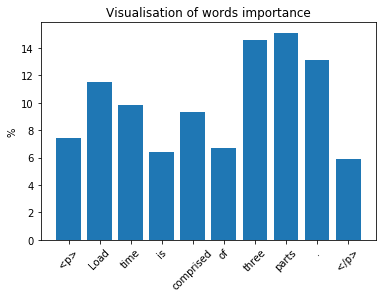

In [19]:
idx = randint(0, len(sentences))
_, _ = model.visualize(sentences[idx])

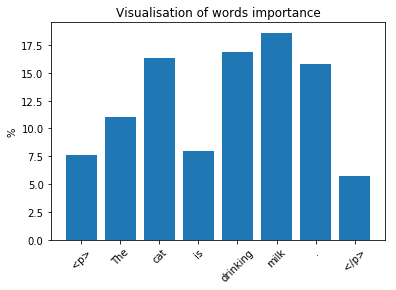

In [20]:
my_sent = 'The cat is drinking milk.'
_, _ = model.visualize(my_sent)

Vocab size : 500000


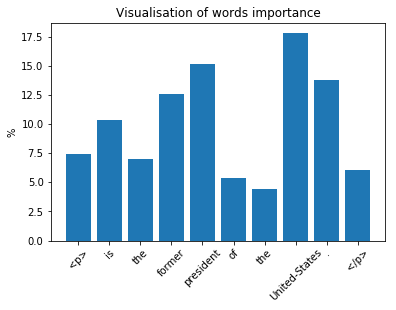

In [21]:
model.build_vocab_k_words(500000) # getting 500K words vocab
my_sent = 'barack-obama is the former president of the United-States.'
_, _ = model.visualize(my_sent)